# Bar Crawl: Detecting Heavy Drinking - Data Visualisation
#### Accelerometer and transdermal alcohol content data from a college bar crawl. Used to predict heavy drinking episodes via mobile data
[Source: http://ceur-ws.org/Vol-2429/paper6.pdf](http://ceur-ws.org/Vol-2429/paper6.pdf)

#### Features: Three-axis time series accelerometer data
#### Target: Time series transdermal alcohol content (TAC) data (real-time measure of intoxication)
The study decomposed each time series into 10 second windows and performed binary classification to predict if windows corresponded to an intoxicated participant (TAC >= 0.08) or sober participant (TAC < 0.08). The study tested several models and achieved a test accuracy of 77.5% with a random forest.

In [1]:
import numpy as np

# Since my computer has limited resources (24GB RAM, 8 cores), I must aggregate the data to accelerate the notebook
AGGREGATE = 25

In [2]:
from pyspark import StorageLevel

from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_replace, collect_list, row_number, floor, avg, lit, coalesce, first, last, array
from pyspark.sql.functions import min, max
from pyspark.sql.functions import when, col
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

#### Load the dataset
The dataset must be downloaded from the source and uploaded to the HDFS. The dataset has the following structure:
.
├── all_accelerometer_data_pids_13.csv
├── clean_tac
 ├── BK7610_clean_TAC.csv
 ├── BU4707_clean_TAC.csv
 ├── ...
 └── 13 files
├── phone_types.csv
├── pids.txt
├── raw_tac
 ├── BK7610 CAM Results.xlsx
 ├── BU4707 CAM results.xlsx
 ├── ...
 └── 13 files
└── README.txt

2 directories, 30 files


In [3]:
# Initialise SparkSession
spark = SparkSession.builder.appName("heavy_drinking_project").config("spark.hadop.fs.defaultFS","hdfs://localhost:9000").getOrCreate()

25/02/20 03:30:12 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.0.1; using 192.168.1.62 instead (on interface wlp61s0)
25/02/20 03:30:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/20 03:30:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load data from HDFS
accelerometer_data = spark.read.csv("hdfs://localhost:9000/heavy_drinking_project/all_accelerometer_data_pids_13.csv", header=True, inferSchema=True)
# Display first 5 rows of data
accelerometer_data.show(5)

+-------------+------+-------+-------+-------+
|         time|   pid|      x|      y|      z|
+-------------+------+-------+-------+-------+
|            0|JB3156|    0.0|    0.0|    0.0|
|            0|CC6740|    0.0|    0.0|    0.0|
|1493733882409|SA0297| 0.0758| 0.0273|-0.0102|
|1493733882455|SA0297|-0.0359| 0.0794| 0.0037|
|1493733882500|SA0297|-0.2427|-0.0861|-0.0163|
+-------------+------+-------+-------+-------+


In [5]:
# Aggregation - Groupby by AGGREGATION rows, avg on values, partition by pid
window_spec = Window.partitionBy("pid").orderBy("time")
accelerometer_data = accelerometer_data.withColumn("row_num", row_number().over(window_spec))
accelerometer_data = accelerometer_data.withColumn("group_num", floor((col("row_num") - 1) / AGGREGATE))
accelerometer_data = accelerometer_data.groupBy("pid", "group_num").agg(
    F.avg("x").alias("x"),
    F.avg("y").alias("y"),
    F.avg("z").alias("z"),
    F.min("time").alias("time")
)
# Delete group_num column
accelerometer_data = accelerometer_data.drop("group_num")

In [6]:
# I have also selected just one of the pid's for acceleration purposes - but since I am using partition, they never get mixed
#accelerometer_data = accelerometer_data.filter((accelerometer_data["pid"] == "SA0297") | (accelerometer_data["pid"] == "BK7610"))
accelerometer_data = accelerometer_data.filter((accelerometer_data["pid"] == "SA0297"))

In [7]:
accelerometer_data.describe().show()

25/02/20 03:30:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------+--------------------+--------------------+--------------------+--------------------+
|summary|   pid|                   x|                   y|                   z|                time|
+-------+------+--------------------+--------------------+--------------------+--------------------+
|  count| 38517|               38517|               38517|               38517|               38517|
|   mean|  NULL|-0.00282075852221...|-4.88142586390434...|-0.00418381628891...|1.493791323299911E12|
| stddev|  NULL| 0.03052992844167898|0.038800349256618634| 0.03335709785051021| 2.348637525551762E7|
|    min|SA0297|           -0.508572| -0.6577640000000001| -1.7064960000000002|       1493733882409|
|    max|SA0297|  0.3392319999999999|  0.6237039999999999|  1.1664119999999998|       1493824735776|
+-------+------+--------------------+--------------------+--------------------+--------------------+


In [8]:
# Number of rows where time in 0
print(f"Numbers of rows with 0: {accelerometer_data.filter(accelerometer_data['time'] == 0).count()}")
# Drop rows where time is 0
accelerometer_data = accelerometer_data.filter(accelerometer_data["time"] != 0)

Numbers of rows with 0: 0


In [9]:
# Check number of distinct pids is 13
accelerometer_data.select("pid").distinct().count()

1

What can we observe first:
- Here the time is measured in milliseconds
- They have different starting and ending times, might occure shorter, or longer breaks

In [10]:
# Min-max values of time / pid
acc_mean_max = accelerometer_data.groupBy("pid").agg(
    min("time").alias("min_value"),
    max("time").alias("max_value")
)
acc_mean_max_value = acc_mean_max.collect()

In [11]:
for row in acc_mean_max_value:
    print("pid: ", row.pid, "min_value: ", row.min_value, "max_value: ", row.max_value)

pid:  SA0297 min_value:  1493733882409 max_value:  1493824735776


In [12]:
# Display statistics of data
accelerometer_data.describe().show()

+-------+------+--------------------+--------------------+--------------------+--------------------+
|summary|   pid|                   x|                   y|                   z|                time|
+-------+------+--------------------+--------------------+--------------------+--------------------+
|  count| 38517|               38517|               38517|               38517|               38517|
|   mean|  NULL|-0.00282075852221...|-4.88142586390434...|-0.00418381628891...|1.493791323299911E12|
| stddev|  NULL| 0.03052992844167898|0.038800349256618634| 0.03335709785051021| 2.348637525551762E7|
|    min|SA0297|           -0.508572| -0.6577640000000001| -1.7064960000000002|       1493733882409|
|    max|SA0297|  0.3392319999999999|  0.6237039999999999|  1.1664119999999998|       1493824735776|
+-------+------+--------------------+--------------------+--------------------+--------------------+


In [13]:
# Persist table in disc
accelerometer_data.persist(StorageLevel.DISK_ONLY)
accelerometer_data.count()

25/02/20 03:31:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


38517

Let's examine the TAC data (the labels) as well

In [14]:
# Load data from HDFS
tac_data = spark.read.csv("hdfs://localhost:9000/heavy_drinking_project/clean_tac", header=True, inferSchema=True)
# Display first 5 rows of data
tac_data.show(5)

+----------+--------------------+
| timestamp|         TAC_Reading|
+----------+--------------------+
|1493720054|-0.00138489147187626|
|1493721878|  8.6409171419157E-4|
|1493722199| 0.00191262269224459|
|1493722520| 0.00133321064411826|
|1493722842| -2.5582927499585E-4|
+----------+--------------------+


In [15]:
# Convert timestamp to milliseconds
tac_data = tac_data.withColumn("timestamp", (col("timestamp").cast("long") * 1000))

In [16]:
tac_data=tac_data.withColumn("pid", input_file_name())
# Clean up the source_file column: remove prefix and suffix
tac_data = tac_data.withColumn(
    "pid",
    regexp_replace(tac_data["pid"], r"hdfs://localhost:9000/heavy_drinking_project/clean_tac/|\_clean_TAC.csv", "")
)
# tac_data.show(5)

In [17]:
# Rename column timestamp to time
tac_data = tac_data.withColumn(
    "label",
    when(col("TAC_Reading") >= 0.08, 1).otherwise(0)
)
tac_data.show(5)

+-------------+--------------------+------+-----+
|    timestamp|         TAC_Reading|   pid|label|
+-------------+--------------------+------+-----+
|1493720054000|-0.00138489147187626|MJ8002|    0|
|1493721878000|  8.6409171419157E-4|MJ8002|    0|
|1493722199000| 0.00191262269224459|MJ8002|    0|
|1493722520000| 0.00133321064411826|MJ8002|    0|
|1493722842000| -2.5582927499585E-4|MJ8002|    0|
+-------------+--------------------+------+-----+


In [18]:
tac_data.describe().show()

+-------+--------------------+-------------------+------+-------------------+
|summary|           timestamp|        TAC_Reading|   pid|              label|
+-------+--------------------+-------------------+------+-------------------+
|  count|                 715|                715|   715|                715|
|   mean|1.493758289310489...|0.04612379015251771|  NULL|0.24335664335664337|
| stddev|2.7079924105804104E7|0.05691672319271539|  NULL|0.42940898745802425|
|    min|       1493716723000|-0.0283076756275948|BK7610|                  0|
|    max|       1493811240000|  0.244715325903414|SF3079|                  1|
+-------+--------------------+-------------------+------+-------------------+


In [19]:
# Filter out the pid's that are in the accelerometer data
tac_data = tac_data.filter(tac_data["pid"] == "SA0297")

In [20]:
# Rename column timestamp to time
tac_data = tac_data.withColumnRenamed("timestamp", "time")
tac_data.persist(StorageLevel.DISK_ONLY)
tac_data.count()
# Join accelerometer and tac data by time and pid
joined_data = accelerometer_data.join(tac_data, ["time", "pid"], "inner")

In [21]:
# Lets see if there are matching timestamps - probably not
joined_data.show(5)

+----+---+---+---+---+-----------+-----+
|time|pid|  x|  y|  z|TAC_Reading|label|
+----+---+---+---+---+-----------+-----+
+----+---+---+---+---+-----------+-----+


In [22]:
# Select time and pid from tac_data, where time is not in accelerometer_data
missing_data = tac_data.join(accelerometer_data, ["time", "pid"], "left_anti")

In [23]:
missing_data.describe().show()

+-------+--------------------+------+--------------------+------------------+
|summary|                time|   pid|         TAC_Reading|             label|
+-------+--------------------+------+--------------------+------------------+
|  count|                  58|    58|                  58|                58|
|   mean|1.493755502568965...|  NULL| 0.04313428279934111|0.1896551724137931|
| stddev|2.8614117773671508E7|  NULL|0.054026349282856004|0.3954520642861982|
|    min|       1493716723000|SA0297| -0.0212745069534411|                 0|
|    max|       1493806094000|SA0297|    0.18264365205783|                 1|
+-------+--------------------+------+--------------------+------------------+


In [24]:
# Min-max values of time / pid - we have to match the timing boundaries
missing_mean_max = missing_data.groupBy("pid").agg(
    min("time").alias("min_value"),
    max("time").alias("max_value")
)
missing_mean_max_value = missing_mean_max.collect()
# Show min-max values of time / pid
for row in missing_mean_max_value:
    print("pid: ", row.pid, "min_value: ", row.min_value, "max_value: ", row.max_value)

pid:  SA0297 min_value:  1493716723000 max_value:  1493806094000


In [25]:
# For every pid, delete records from missing_data where missing_row.pid==acc_row.pid, missing_df[time] is less than acc_row.min_value or greater than acc_row.max_value
filtered_missing_data = spark.createDataFrame([], missing_data.schema)
for row in acc_mean_max_value:
    filtered = missing_data.filter((missing_data["pid"] == row.pid) & (missing_data["time"] >= row.min_value) & (missing_data["time"] <= row.max_value))
    filtered_missing_data = filtered_missing_data.union(filtered)

In [26]:
# Min-max values of time / pid
filtered_min_max = filtered_missing_data.groupBy("pid").agg(
    min("time").alias("min_value"),
    max("time").alias("max_value")
)
filtered_min_max_value = filtered_min_max.collect()

In [27]:
for row in filtered_min_max_value:
    print("pid: ", row.pid, "min_value: ", row.min_value, "max_value: ", row.max_value)

pid:  SA0297 min_value:  1493734448000 max_value:  1493806094000


In [28]:
missing_data = filtered_missing_data

In [29]:
# Add columns x, y, z to missing_data with null values
missing_data = missing_data \
    .withColumn("id", lit(0).cast("int")) \
    .withColumn("x", lit(None).cast("double")) \
    .withColumn("y", lit(None).cast("double")) \
    .withColumn("z", lit(None).cast("double"))
# missing_data.show(5)

In [30]:
accelerometer_data = accelerometer_data \
    .withColumn("TAC_Reading", lit(None).cast("double")) \
    .withColumn("label", lit(None).cast("int"))

In [31]:
# Add missing_data to accelerometer_data, the order of columns might differ
missing_data = missing_data.select(accelerometer_data.columns)
accelerometer_data = accelerometer_data.union(missing_data)

In [32]:
# Update row number
window_spec = Window.partitionBy("pid").orderBy("time")
accelerometer_data = accelerometer_data.withColumn("id", row_number().over(window_spec))

In [33]:
# As we can see, there are a lot of null values. We will aproach them linearly
missing_data.describe().show()

+-------+------+----+----+----+--------------------+-------------------+------------------+
|summary|   pid|   x|   y|   z|                time|        TAC_Reading|             label|
+-------+------+----+----+----+--------------------+-------------------+------------------+
|  count|    40|   0|   0|   0|                  40|                 40|                40|
|   mean|  NULL|NULL|NULL|NULL|   1.493770315025E12|0.06184838344957734|             0.275|
| stddev|  NULL|NULL|NULL|NULL|2.1507314503191642E7|0.05533492589476571|0.4522025867763026|
|    min|SA0297|NULL|NULL|NULL|       1493734448000|-0.0212745069534411|                 0|
|    max|SA0297|NULL|NULL|NULL|       1493806094000|   0.18264365205783|                 1|
+-------+------+----+----+----+--------------------+-------------------+------------------+


In [34]:
accelerometer_data.describe().show()

+-------+------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|summary|   pid|                   x|                   y|                   z|                time|        TAC_Reading|             label|                id|
+-------+------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|  count| 38557|               38517|               38517|               38517|               38557|                 40|                40|             38557|
|   mean|  NULL|-0.00282075852221...|-4.88142586390434...|-0.00418381628891...|1.493791301505399...|0.06184838344957734|             0.275|           19279.0|
| stddev|  NULL| 0.03052992844167898|0.038800349256618634| 0.03335709785051021|2.3493889572965868E7|0.05533492589476571|0.4522025867763026|11130.591501203638|
|    min|SA0297|           -0.508572| -0.65776

In [35]:
# Sort data by pid and time
accelerometer_data = accelerometer_data.orderBy("pid", "time")

In [36]:
# Define a window for previous and next records
window_spec = Window.partitionBy("pid").orderBy("time").rowsBetween(-1, 1)

In [37]:
# If null, then avg of col
accelerometer_data = accelerometer_data.withColumn(
    "x",
    coalesce(accelerometer_data["x"], avg("x").over(window_spec))
).withColumn(
    "y",
    coalesce(accelerometer_data["y"], avg("y").over(window_spec))
).withColumn(
    "z",
    coalesce(accelerometer_data["z"], avg("z").over(window_spec))
)

In [38]:
accelerometer_data.describe().show()

+-------+------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|summary|   pid|                   x|                   y|                   z|                time|        TAC_Reading|             label|                id|
+-------+------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+
|  count| 38557|               38548|               38548|               38548|               38557|                 40|                40|             38557|
|   mean|  NULL|-0.00281995309743...|-4.93151343779193...|-0.00417357030196...|1.493791301505399...|0.06184838344957734|             0.275|           19279.0|
| stddev|  NULL|0.030540461879194295| 0.03882463927784377| 0.03338407605037276|2.3493889572965868E7|0.05533492589476571|0.4522025867763026|11130.591501203638|
|    min|SA0297|           -0.508572| -0.65776

In [39]:
# Drop rows where x, y, z is null
accelerometer_data = accelerometer_data.filter(accelerometer_data["x"].isNotNull() & accelerometer_data["y"].isNotNull() & accelerometer_data["z"].isNotNull())

In [40]:
# Add new row, with mintime-1 and maxtime+1
for row in acc_mean_max_value:
    new_row = spark.createDataFrame([(row.pid, 0.0, 0.0, 0.0, row.min_value - 1, 0.0, 0, 0), (row.pid, 0.0, 0.0, 0.0, row.max_value + 1, 0.0,0, accelerometer_data.filter(accelerometer_data["pid"] == row.pid).count())], accelerometer_data.schema)
    accelerometer_data = accelerometer_data.union(new_row)

In [41]:
window_spec_prev = Window.partitionBy("pid").orderBy("time").rowsBetween(Window.unboundedPreceding, Window.currentRow)
window_spec_next = Window.partitionBy("pid").orderBy("time").rowsBetween(Window.currentRow, Window.unboundedFollowing)

In [42]:
accelerometer_data = accelerometer_data.withColumn("prev_tac", last("TAC_Reading", ignorenulls=True).over(window_spec_prev))
accelerometer_data = accelerometer_data.withColumn("prev_index", last(when(col("TAC_Reading").isNotNull(), col("id")), ignorenulls=True).over(window_spec_prev))
accelerometer_data = accelerometer_data.withColumn("next_tac", first("TAC_Reading", ignorenulls=True).over(window_spec_next))
accelerometer_data = accelerometer_data.withColumn("next_index", first(when(col("TAC_Reading").isNotNull(), col("id")), ignorenulls=True).over(window_spec_next))

In [43]:
accelerometer_data = accelerometer_data.withColumn("count_since_prev", col("id") - col("prev_index"))
accelerometer_data = accelerometer_data.withColumn("count_until_next", col("next_index") - col("id"))

accelerometer_data = accelerometer_data.withColumn("pos_ratio", col("count_since_prev") / (col("count_since_prev") + col("count_until_next")))

In [44]:
accelerometer_data = accelerometer_data.withColumn("TAC_Reading", when(col("TAC_Reading").isNotNull(), col("TAC_Reading")).otherwise(col("prev_tac") + (col("next_tac") - col("prev_tac")) * col("pos_ratio")))

In [45]:
# Drop columns for calculating interpolated_tac
accelerometer_data = accelerometer_data.drop("prev_tac", "prev_index", "next_tac", "next_index", "count_since_prev", "count_until_next", "pos_ratio")

In [46]:
accelerometer_data.filter(accelerometer_data["time"] >= "1493734446000").show(5)

+------+--------------------+-------------------+--------------------+-------------+--------------------+-----+---+
|   pid|                   x|                  y|                   z|         time|         TAC_Reading|label| id|
+------+--------------------+-------------------+--------------------+-------------+--------------------+-----+---+
|SA0297|-0.03500799999999999|           0.094412|-0.02873599999999...|1493734446025|0.032522124627376636| NULL|433|
|SA0297|           -0.071504|           0.079016|-0.00847600000000...|1493734447157| 0.03259723346023432| NULL|434|
|SA0297|           -0.052636|           0.091216|-0.03497000000000...|1493734448000|   0.032672342293092|    0|435|
|SA0297|           -0.033768|0.10341600000000001|-0.06146400000000002|1493734448287| 0.03265971419519542| NULL|436|
|SA0297|0.002504000000000...|0.13429199999999997|-0.02044800000000...|1493734449412| 0.03264708609729885| NULL|437|
+------+--------------------+-------------------+--------------------+--

In [47]:
# Label data
accelerometer_data = accelerometer_data.withColumn("label", when(col("TAC_Reading") >= 0.08, 1).otherwise(0))

In [48]:
# Persist table in disc, to load it faster
accelerometer_data.persist(StorageLevel.DISK_ONLY)
accelerometer_data.count()

38550

#### Feature engineering
As the paper sugests, the data is not seperable by the accelerometer data alone. We need to use feature engineering to get the best results.

In [49]:
# Window for last 20 rows
w_size = (int)(20000 / (AGGREGATE * 45)) + 1
window = Window.partitionBy("pid").orderBy("time")
window_20 = Window.partitionBy("pid").orderBy("time").rowsBetween(-w_size, 0)

#### Calculate the velocity and distance from the accelerometer data
Improved the modell weakly, not used in the final model

In [50]:
# Add column dt
accelerometer_data = accelerometer_data.withColumn("dt", (F.col("time") - F.lag("time", 1).over(window)) / 1000)
# Fill null values with 0 in dt
accelerometer_data = accelerometer_data.fillna(0, subset=["dt"])

In [51]:
# Calculate vx, vy, vz from accelerations x,y,z
accelerometer_data = accelerometer_data.withColumn(
    "vx",
    F.sum(F.col("x") * F.col("dt")).over(window_20)
).withColumn(
    "vy",
    F.sum(F.col("y") * F.col("dt")).over(window_20)
).withColumn(
    "vz",
    F.sum(F.col("z") * F.col("dt")).over(window_20)
)

In [52]:
# Calculator velocity
accelerometer_data = accelerometer_data.withColumn(
    "a",
    F.sqrt(F.col("x") ** 2 + F.col("y") ** 2 + F.col("z") ** 2)
).withColumn(
    "v",
    F.sum(F.col("a") * F.col("dt")).over(window_20)
)

In [53]:
# Calculate dx, dy, dz from velocities vx, vy, vz
accelerometer_data = accelerometer_data.withColumn(
    "dx",
    F.sum(F.col("vx") * F.col("dt")).over(window_20)
).withColumn(
    "dy",
    F.sum(F.col("vy") * F.col("dt")).over(window_20)
).withColumn(
    "dz",
    F.sum(F.col("vz") * F.col("dt")).over(window_20)
)

#### Approach with first and second derivative
Did not improve the model significantly, not used in the final model

In [54]:
# Calculate distance between the prev row and the current row in distance column
accelerometer_data = accelerometer_data.withColumn(
    "distance",
    F.sqrt(
        (F.col("x") - F.lag("x", 1).over(window)) ** 2 +
        (F.col("y") - F.lag("y", 1).over(window)) ** 2 +
        (F.col("z") - F.lag("z", 1).over(window)) ** 2
    )
)

In [55]:
# Calculate velocity between the prev row and the current row in velocity column
# Sum the prev 20 distance, divide it by the difference of the current time and the prev time and multiple by 1000
accelerometer_data = accelerometer_data.withColumn(
    "velocity",
    F.sum("distance").over(window_20) / ((F.col("time") - F.lag("time", 20).over(window)) / 10000)
)
    

In [56]:
# Calculate the velocity difference between the current row and the next row in velocity_diff column
accelerometer_data = accelerometer_data.withColumn(
    "velocity_diff",
    F.col("velocity") - F.lead("velocity", 1).over(window)
)

In [57]:
# Calculate the acceleration between the current row and the next row in acceleration column
# Sum the prev 20 velocity_diff, divide it by the difference of the current time and the prev time and multiple by 1000
accelerometer_data = accelerometer_data.withColumn(
    "acceleration",
    F.sum("velocity_diff").over(window_20) / ((F.col("time") - F.lag("time", 20).over(window)) / 10000)
)

#### Trying with paper approach
The paper advised several features to be used based on the lest 1 and 10 seconds of the data - here I used 5 and 30 seconds

In [58]:
sec_1 = (int)(5000 / (AGGREGATE * 45)) + 1
sec_10 = (int)(30000 / (AGGREGATE * 45)) + 1
window_1sec = Window.partitionBy("pid").orderBy("time").rowsBetween(-sec_1, 0)
window_10sec = Window.partitionBy("pid").orderBy("time").rowsBetween(-sec_10, 0)

In [59]:
feature_columns = ["x", "y", "z"]

In [60]:
for window in [window_1sec, window_10sec]:
    for dim in ["x", "y", "z"]:
        feature_columns.append(f"mean_{dim}_1sec")
        feature_columns.append(f"std_{dim}_1sec")
        feature_columns.append(f"median_{dim}_1sec")
        feature_columns.append(f"variance_{dim}_1sec")
        feature_columns.append(f"min_{dim}_1sec")
        feature_columns.append(f"max_{dim}_1sec")
        feature_columns.append(f"mean_{dim}_10sec")
        feature_columns.append(f"std_{dim}_10sec")
        feature_columns.append(f"median_{dim}_10sec")
        feature_columns.append(f"variance_{dim}_10sec")
        feature_columns.append(f"min_{dim}_10sec")
        feature_columns.append(f"max_{dim}_10sec")
        
        accelerometer_data = accelerometer_data.withColumn(
            f"mean_{dim}_1sec",
            F.avg(dim).over(window)
        ).withColumn(
            f"std_{dim}_1sec",
            F.stddev(dim).over(window)
        ).withColumn(
            f"median_{dim}_1sec",
            F.expr(f"percentile_approx({dim}, 0.5)").over(window)
        ).withColumn(
            f"variance_{dim}_1sec",
            F.variance(dim).over(window)
        ).withColumn(
            f"min_{dim}_1sec",
            F.min(dim).over(window)
        ).withColumn(
            f"max_{dim}_1sec",
            F.max(dim).over(window)
        ).withColumn(
            f"mean_{dim}_10sec",
            F.avg(dim).over(window)
        ).withColumn(
            f"std_{dim}_10sec",
            F.stddev(dim).over(window)
        ).withColumn(
            f"median_{dim}_10sec",
            F.expr(f"percentile_approx({dim}, 0.5)").over(window)
        ).withColumn(
            f"variance_{dim}_10sec",
            F.variance(dim).over(window)
        ).withColumn(
            f"min_{dim}_10sec",
            F.min(dim).over(window)
        ).withColumn(
            f"max_{dim}_10sec",
            F.max(dim).over(window)
        )
        print(f"Finished {dim}")   

Finished x
Finished y
Finished z
Finished x
Finished y
Finished z


In [61]:
accelerometer_data.describe().show()

+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-----------------+------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------

#### Save data

In [62]:
# Remove null values
accelerometer_data = accelerometer_data.na.drop()
# Drop velocity_diff column
accelerometer_data = accelerometer_data.drop("velocity_diff")

In [63]:
accelerometer_data.persist(StorageLevel.DISK_ONLY)
accelerometer_data.count()

38529

In [64]:
accelerometer_data.show(5)

+------+--------------------+--------------------+--------------------+-------------+--------------------+-----+---+-----+-------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

In [65]:
# Plot TAC_Reading
import matplotlib.pyplot as plt
import pandas as pd
tac_reading = accelerometer_data.select("time", "TAC_Reading", "acceleration", "velocity", "x", "y", "z", 'mean_x_1sec',"std_x_1sec", "max_x_10sec").toPandas()

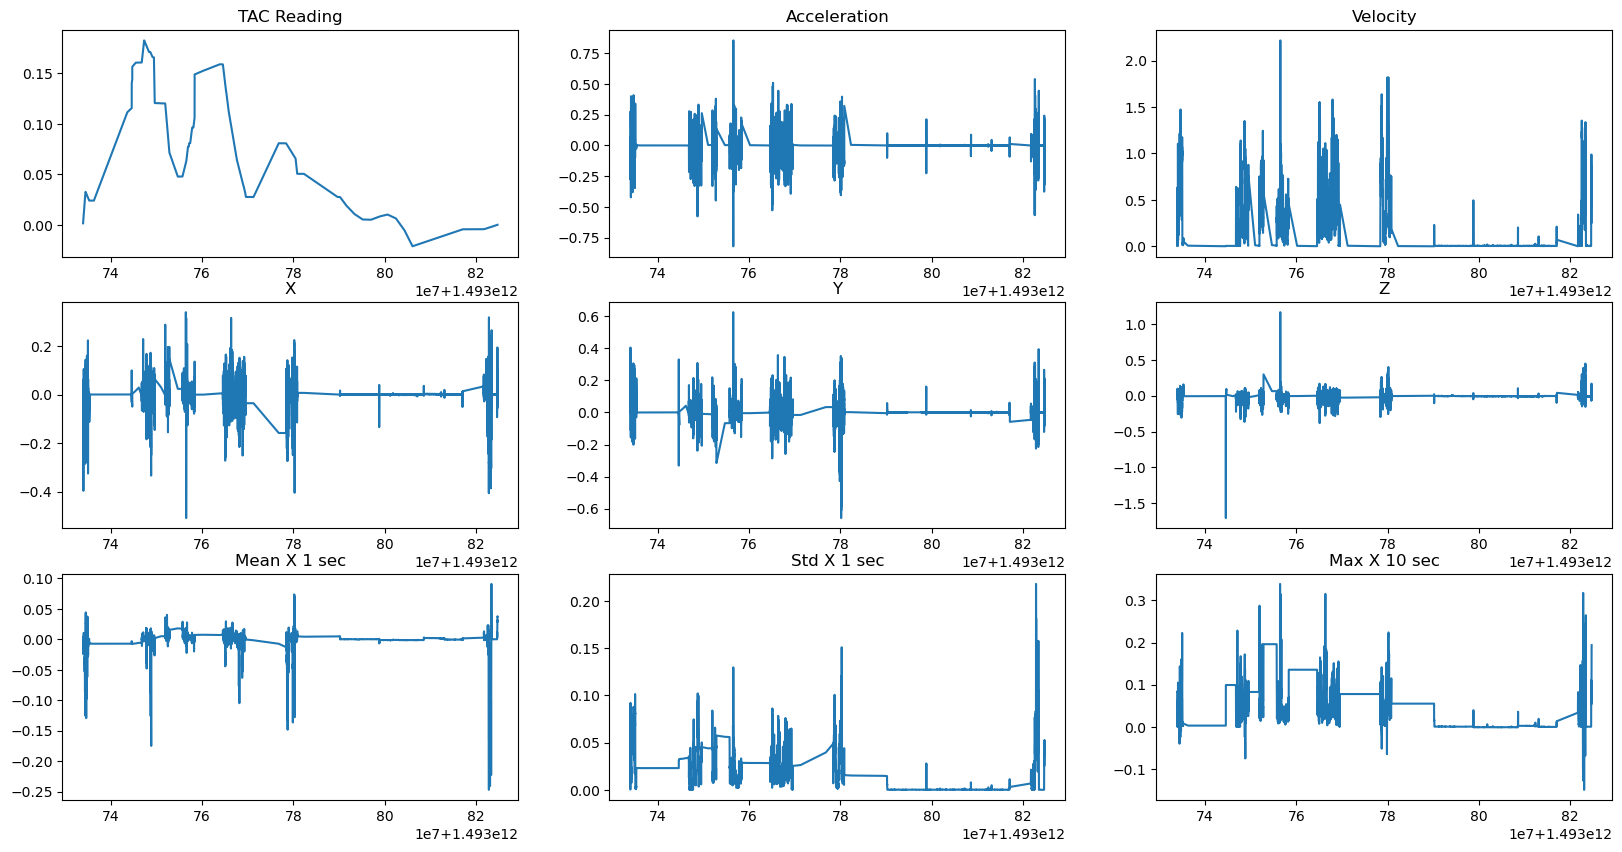

In [66]:
# Plot six columns
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
axs[0, 0].plot(tac_reading["time"], tac_reading["TAC_Reading"])
axs[0, 0].set_title("TAC Reading")
axs[0, 1].plot(tac_reading["time"], tac_reading["acceleration"])
axs[0, 1].set_title("Acceleration")
axs[0, 2].plot(tac_reading["time"], tac_reading["velocity"])
axs[0, 2].set_title("Velocity")
axs[1, 0].plot(tac_reading["time"], tac_reading["x"])
axs[1, 0].set_title("X")
axs[1, 1].plot(tac_reading["time"], tac_reading["y"])
axs[1, 1].set_title("Y")
axs[1, 2].plot(tac_reading["time"], tac_reading["z"])
axs[1, 2].set_title("Z")
axs[2, 0].plot(tac_reading["time"], tac_reading["mean_x_1sec"])
axs[2, 0].set_title("Mean X 1 sec")
axs[2, 1].plot(tac_reading["time"], tac_reading["std_x_1sec"])
axs[2, 1].set_title("Std X 1 sec")
axs[2, 2].plot(tac_reading["time"], tac_reading["max_x_10sec"])
axs[2, 2].set_title("Max X 10 sec")
plt.show()

# Decision tree

In [67]:
accelerometer_data.show(5)

+------+--------------------+--------------------+--------------------+-------------+--------------------+-----+---+-----+-------------------+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+-------------------+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-

In [68]:
dataset = accelerometer_data

In [69]:
dataset.count()

38529

In [70]:
window_size = 25
window_spec = Window.partitionBy("pid").orderBy("time").rowsBetween(-(window_size // 2), (window_size // 2)) # 1/45 milisecs, 50 aggregations = 54 second on avg

In [71]:
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="vector"
)

In [72]:
dataset = assembler.transform(dataset)

In [73]:
dataset = dataset.withColumn(
    "feature", 
    collect_list("vector").over(window_spec)
)

In [74]:
dataset = dataset.filter(F.size(dataset.feature) == window_size)

In [75]:
from pyspark.ml.linalg import VectorUDT


def merge_vectors(vectors):
    if vectors is None:
        return None
    merged_array = []
    for v in vectors:
        merged_array.extend(v.toArray())
    return Vectors.dense(merged_array)

merged_vectors = F.udf(merge_vectors, VectorUDT())

In [76]:
dataset = dataset.withColumn("flat_feature", merged_vectors("feature"))

In [77]:
dataset.describe().show(5)

+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+------------------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------

In [78]:
# Count of rows to variable, where label is 0
count_label_0 = dataset.filter(dataset["label"] == 0).count()
# Count of rows to variable, where label is 1
count_label_1 = dataset.filter(dataset["label"] == 1).count()

In [79]:
print(f"Label 0 count: {count_label_0}, Label 1 count: {count_label_1}")

Label 0 count: 32957, Label 1 count: 5548


In [80]:
# Randomly del rows, so count_label_0 == count_label_1
dataset = dataset.filter(dataset["label"] == 0).limit(count_label_1).union(dataset.filter(dataset["label"] == 1))
dataset.persist(StorageLevel.DISK_ONLY)
dataset.count()

11096

In [81]:
train, test = dataset.randomSplit([0.8, 0.2], seed=42)

In [82]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="flat_feature", numTrees=50)
model = rf.fit(train)

25/02/20 03:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/02/20 03:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
25/02/20 03:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
25/02/20 03:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1143.7 KiB
25/02/20 03:38:02 WARN DAGScheduler: Broadcasting large task binary with size 1251.3 KiB


In [83]:
pred = model.transform(test)

In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print(f"Random Forest accuracy: {accuracy}")


Random Forest accuracy: 0.7888227210261108


In [85]:
pred.describe().show()

25/02/20 03:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1240.3 KiB


+-------+------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+-------------------+-------------------+------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [86]:
# Plot predictions
pred_pd = pred.select("time", 'TAC_Reading', "label", "prediction").toPandas()
# order by time
pred_pd = pred_pd.sort_values("time")

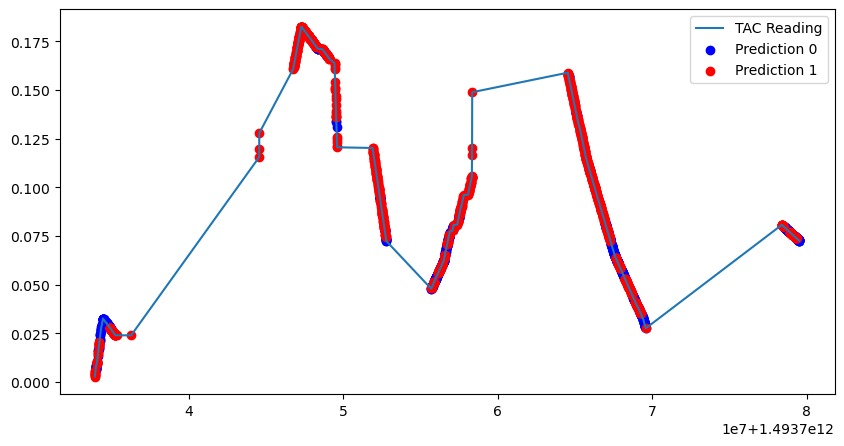

In [87]:
# Blue, if prediction is 0, red if prediction is 1
plt.figure(figsize=(10, 5))
plt.plot(pred_pd["time"], pred_pd["TAC_Reading"], label="TAC Reading")
plt.scatter(pred_pd[pred_pd["prediction"] == 0]["time"], pred_pd[pred_pd["prediction"] == 0]["TAC_Reading"], color="blue", label="Prediction 0")
plt.scatter(pred_pd[pred_pd["prediction"] == 1]["time"], pred_pd[pred_pd["prediction"] == 1]["TAC_Reading"], color="red", label="Prediction 1")
plt.legend()

## NN and CNN model approach
Even in the paer it was mentioned, that neural networks does not challange the accuracy of the random forest model
My experiments supported this statement, but I will show the approach

In [88]:
import tensorflow as tf
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf
from pyspark.sql.types import ArrayType, FloatType
import pandas as pd
import numpy as np

2025-02-20 03:38:42.155952: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740019122.183268 3354307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740019122.192815 3354307 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 03:38:42.226774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [89]:
# UDF for converting to numpy array
def to_numpy(array):
    return np.array(array, dtype=np.float32).tolist()
to_numpy_udf = udf(to_numpy, ArrayType(ArrayType(FloatType())))

In [90]:
dataset.feature

Column<'feature'>

In [91]:
dataset = dataset.withColumn("feature_numpy", to_numpy_udf(dataset.feature))

In [92]:
# Add batch_id to dataset
batch_size = 64
num_epochs = 5
trainset, valset, testset = dataset.randomSplit([0.7, 0.15, 0.15], seed=42)
dataset_len = trainset.count()
trainset = trainset.withColumn("batch_id", (F.randn() * (dataset_len // batch_size + 1)).cast("int"))
trainset.persist(StorageLevel.DISK_ONLY)
dataset.count()

11096

In [93]:
valset_len = valset.count()
valset = valset.withColumn("batch_id", (F.randn() * (valset_len // batch_size + 1)).cast("int"))
valset.persist(StorageLevel.DISK_ONLY)
valset.count()

1654

In [94]:
batch_data_rdd = trainset.rdd.map(lambda row: (row["batch_id"], (row["feature_numpy"], row["label"]))) \
                       .groupByKey() \
                       .mapValues(list) \
                       .sortByKey()

In [95]:
val_batch_data_rdd = valset.rdd.map(lambda row: (row["batch_id"], (row["feature_numpy"], row["label"]))) \
                        .groupByKey() \
                        .mapValues(list) \
                        .sortByKey()

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [101]:
# NN model - first, a more simple model
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(1875, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = Fun.relu(self.fc1(x))
        x = Fun.relu(self.fc2(x))
        x = Fun.relu(self.fc3(x))
        x = Fun.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x        

In [102]:
# CNN model - a more advanced model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(7, 7), padding=3)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))  # Reduces (25,75) -> (12,37)
        
        # Convolutional Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(7, 7), padding=3)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(7, 7), padding=3)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))  # Reduces (12,37) -> (6,18)
        
        # Convolutional Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(7, 7), padding=3)
        self.batchnorm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(7, 7), padding=3)
        self.batchnorm6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))  # Reduces (6,18) -> (3,9)
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Output shape -> [batch, 128, 1, 1]
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Convolutional Block 1
        x = Fun.selu(self.batchnorm1(self.conv1(x)))
        x = Fun.selu(self.batchnorm2(self.conv2(x)))
        x = self.pool1(x)
        
        # Convolutional Block 2
        x = Fun.selu(self.batchnorm3(self.conv3(x)))
        x = Fun.selu(self.batchnorm4(self.conv4(x)))
        x = self.pool2(x)
        
        # Convolutional Block 3
        x = Fun.selu(self.batchnorm5(self.conv5(x)))
        x = Fun.selu(self.batchnorm6(self.conv6(x)))
        x = self.pool3(x)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten to [batch, 128]
        
        # Fully Connected Layers
        x = self.dropout(Fun.selu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))  # Binary classification output
        
        return x


In [103]:
# Training function
def train_model_batch(model,batch_data_rdd, batch_size=256, num_epochs=10):
    criterion = nn.BCELoss()  # Binary classification loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        
        epoch_loss = 0
        batch_count = 0
        
        model.train()
        for batch_id, batch_data in batch_data_rdd.collect():
            features = [torch.tensor(f, dtype=torch.float32).unsqueeze(0) for f, _ in batch_data]
            labels = [torch.tensor(l, dtype=torch.float32) for _, l in batch_data]
            
            #Convert to tensors
            inputs = torch.stack(features)  # [batch_size, 1, 25, 3]
            labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
          
        # Validation loss    
        model.eval()
        val_epoch_loss = 0
        val_batch_count = 0
        for batch_id, batch_data in val_batch_data_rdd.collect():
            features = [torch.tensor(f, dtype=torch.float32).unsqueeze(0) for f, _ in batch_data]
            labels = [torch.tensor(l, dtype=torch.float32) for _, l in batch_data]
            
            #Convert to tensors
            inputs = torch.stack(features)
            labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_epoch_loss += loss.item()
            val_batch_count += 1
        
            
        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)
        avg_val_loss = val_epoch_loss / val_batch_count
        val_loss_history.append(avg_val_loss)
        print(f"Epoch {epoch+1} loss: {avg_loss:.4f} val_loss: {avg_val_loss:.4f}")
    return model

In [104]:
# Modell betanítása minden batch-en
model = train_model_batch(NN(),batch_data_rdd, batch_size=batch_size, num_epochs=5)

Epoch 1/5


Epoch 1 loss: 0.6236 val_loss: 0.6074
Epoch 2/5


Epoch 2 loss: 0.5662 val_loss: 0.5530
Epoch 3/5


Epoch 3 loss: 0.5436 val_loss: 0.5952
Epoch 4/5


Epoch 4 loss: 0.5103 val_loss: 0.5689
Epoch 5/5


Epoch 5 loss: 0.5188 val_loss: 0.5475


In [105]:
cnn_model = train_model_batch(CNN(),batch_data_rdd, batch_size=batch_size, num_epochs=5)

Epoch 1/5


Epoch 1 loss: 0.7000 val_loss: 0.6931
Epoch 2/5


Epoch 2 loss: 0.6842 val_loss: 0.6661
Epoch 3/5


Epoch 3 loss: 0.6615 val_loss: 0.6551
Epoch 4/5


Epoch 4 loss: 0.6548 val_loss: 0.6625
Epoch 5/5


Epoch 5 loss: 0.6512 val_loss: 0.6758


In [106]:
# UDF for prediction
@udf("float")
def predict(model, features):
    with torch.no_grad():
        input_tensor = torch.tensor([features], dtype=torch.float32).unsqueeze(0)  # [1, 1, 25, 3]
        output = model(input_tensor)
        # Round to 0 or 1
        return torch.round(output).item()

In [107]:
# Prediction
dataset = testset.withColumn("prediction", predict(model,dataset.feature_numpy).cast("double"))

In [108]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dataset)
print(f"NN accuracy: {accuracy}")

CNN accuracy: 0.6331904470300062


In [ ]:
dataset = testset.withColumn("prediction", predict(cnn_model,dataset.feature_numpy).cast("double"))

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(dataset)
print(f"CNN accuracy: {accuracy}")